In [29]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import CoherenceModel
import gensim.corpora as corpora

# Read in Dataset

In [2]:
df = pd.read_csv('../data/curated/reviews/cleaned_reviews.csv')
df

,Sentiment,Time,Text,processed_text
0,1,18/6/21,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...
1,1,7/7/21,I've been very pleased with the Natural Balanc...,pleased natural balance dog food dog issue dog...
2,1,18/6/21,"Before I was educated about feline nutrition, ...",educate feline nutrition allow cat become addi...
3,1,7/7/21,"My holistic vet recommended this, along with a...",holistic vet recommend along brand try cat pre...
4,1,1/7/21,I bought this coffee because its much cheaper ...,buy coffee much cheaper ganocafe organic reish...
...,...,...,...,...
5439,0,26/2/21,"This is an okay gift box, only if you like med...",okay gift box like mediocre cheese summer saus...
5440,0,18/12/19,It looks llike I just walked into a raw deal. ...,look llike walked raw deal item intolerably st...
5441,0,19/1/20,Thank god that i tasted the metal before i swa...,thank god taste metal swallow dont even get ge...
5442,0,13/9/20,This product was very good when I began buying...,product good begin buy lately terrible taste r...


# TF-IDF

In [3]:
vectorizer = TfidfVectorizer(lowercase=True,
                             analyzer='word',
                             stop_words = 'english',
                             ngram_range = (1,1),
                             max_df = 0.75,
                             min_df = 50,
                             max_features=10000)
vectorized_text = vectorizer.fit_transform(df['processed_text'])

In [181]:
vectorized_text.shape

(5444, 499)

In [182]:
vectorizer.get_feature_names_out()

array(['able', 'absolutely', 'actually', 'add', 'aftertaste', 'ago',
       'almond', 'alternative', 'amaze', 'amazon', 'apple', 'aroma',
       'arrive', 'artificial', 'ask', 'ate', 'available', 'avoid', 'away',
       'awesome', 'baby', 'bad', 'bag', 'bake', 'bar', 'base', 'batch',
       'bean', 'beat', 'believe', 'benefit', 'best', 'better', 'beverage',
       'big', 'bit', 'bite', 'bitter', 'black', 'blend', 'bottle',
       'bought', 'bowl', 'box', 'brand', 'bread', 'break', 'breakfast',
       'brew', 'bring', 'brown', 'bulk', 'butter', 'buy', 'buying',
       'cake', 'calorie', 'candy', 'carbs', 'care', 'carry', 'case',
       'cat', 'cause', 'cereal', 'certainly', 'change', 'cheap',
       'cheaper', 'check', 'cheese', 'chemical', 'chew', 'chewy',
       'chicken', 'child', 'china', 'chip', 'chocolate', 'choice',
       'cinnamon', 'clean', 'close', 'coat', 'cocoa', 'coconut', 'coffee',
       'cold', 'color', 'com', 'come', 'company', 'compare', 'complaint',
       'completel

# LDA

In [6]:
#Coherance Score function 
#The higher the better. Input: Sklearn Model, output: Coherance score

def get_Cv(model, df_columnm):
  topics = model.components_
  n_top_words = 20
  texts = [[word for word in doc.split()] for doc in df_columnm]
  # create the dictionary
  dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix
  # Create a gensim corpus from the word count matrix
  corpus = [dictionary.doc2bow(text) for text in texts]
  feature_names = [dictionary[i] for i in range(len(dictionary))]
  # Get the top words for each topic from the components_ attribute
  top_words = []
  for topic in topics:
      top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
  coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

In [7]:
#Finding the right number of topis (n_components)

cv_scores = []
lg_scores = []
perp_scores = []

for i in range(1,11):
    lda_model = LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
 evaluate_every=-1, learning_decay=0.7,
 learning_method='online', learning_offset=50,
 max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
 n_components=i, n_jobs=-1, perp_tol=0.1,
 random_state=20, topic_word_prior=None,
 total_samples=1000000.0, verbose=0)

    lda_topics = lda_model.fit_transform(vectorized_text)
    
    cv_scores.append(get_Cv(lda_model,df['processed_text']))
    lg_scores.append(lda_model.score(vectorized_text))
    perp_scores.append(lda_model.perplexity(vectorized_text))
    # See model parameters
    #print(lda_model.get_params())

Text(0, 0.5, 'Perplexity')

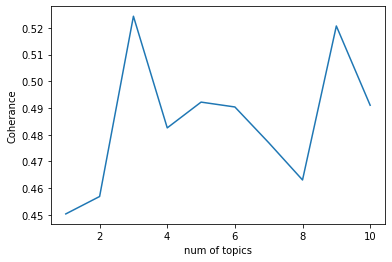

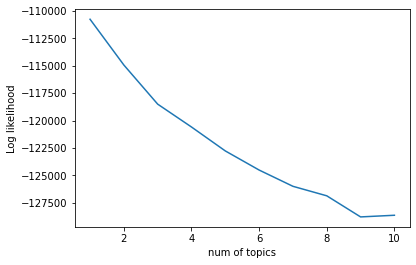

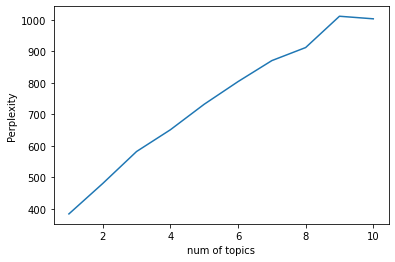

In [8]:
x = np.array(range(1,11))
plt.plot(x,cv_scores)
plt.xlabel("num of topics")
plt.ylabel("Coherance")
plt.figure()
plt.plot(x,lg_scores) 
plt.xlabel("num of topics")
plt.ylabel("Log likelihood")
plt.figure()
plt.plot(x,perp_scores)
plt.xlabel("num of topics")
plt.ylabel("Perplexity") 

In [9]:
cv_scores 
#choose topics = 3 due to highest CV score & lower perplexity than topic = 9

[0.4502849373792383,
 0.4568159285041642,
 0.5243971432366218,
 0.4825400802938184,
 0.4922032970413587,
 0.4903806086957921,
 0.4769933645403962,
 0.463016601477941,
 0.5207471627180221,
 0.4910273856325076]

In [4]:
# lda component: for each topic, the prob of each word in the vocabulary
lda_model = LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
 evaluate_every=-1, learning_decay=0.7,
 learning_method='online', learning_offset=50,
 max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
 n_components=3, n_jobs=-1, perp_tol=0.1,
 random_state=20, topic_word_prior=None,
 total_samples=1000000.0, verbose=0)

lda_topics = lda_model.fit_transform(vectorized_text)
lda_model.components_.shape

(3, 499)

Topic 0: 
coffee price buy cup product dog great taste love like
Topic 1: 
order product great good free price chip taste love tasty
Topic 2: 
tea taste flavor like drink water use good great try


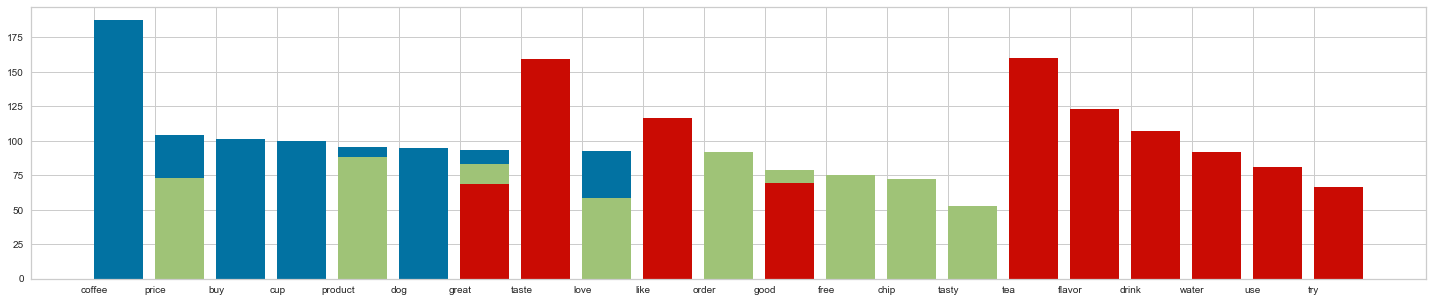

In [201]:
#Top n =  words in each topic shown

x = {}
vocab = vectorizer.get_feature_names_out()
for i, comp in enumerate(lda_model.components_):
    #x_mat = comp>np.median(comp)
    #x_index = np.where(x_mat)[0]
    #vocab_index = vocab[x_index]
    #comp_index = comp[x_index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key = lambda x:x[1], reverse = True)
    value_key = [i[0] for i in sorted_words]
    value_count = [i[1] for i in sorted_words]
    plt.rcParams['figure.figsize'] = [25, 5]
    plt.bar(value_key[:10],value_count[:10],align='edge')
    #plt.figure()
    print("Topic " + str(i) + ": ")
    print(" ".join([i[0] for i in sorted_words[:10]]))

In [5]:
dominant_topic_list = [np.where(topic == np.max(topic))[0][0] for topic in lda_topics]
df['dominant_topic'] = dominant_topic_list
df

,Sentiment,Time,Text,processed_text,dominant_topic
0,1,18/6/21,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...,0
1,1,7/7/21,I've been very pleased with the Natural Balanc...,pleased natural balance dog food dog issue dog...,0
2,1,18/6/21,"Before I was educated about feline nutrition, ...",educate feline nutrition allow cat become addi...,0
3,1,7/7/21,"My holistic vet recommended this, along with a...",holistic vet recommend along brand try cat pre...,2
4,1,1/7/21,I bought this coffee because its much cheaper ...,buy coffee much cheaper ganocafe organic reish...,0
...,...,...,...,...,...
5439,0,26/2/21,"This is an okay gift box, only if you like med...",okay gift box like mediocre cheese summer saus...,1
5440,0,18/12/19,It looks llike I just walked into a raw deal. ...,look llike walked raw deal item intolerably st...,1
5441,0,19/1/20,Thank god that i tasted the metal before i swa...,thank god taste metal swallow dont even get ge...,2
5442,0,13/9/20,This product was very good when I began buying...,product good begin buy lately terrible taste r...,0


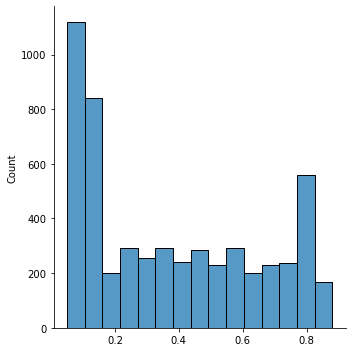

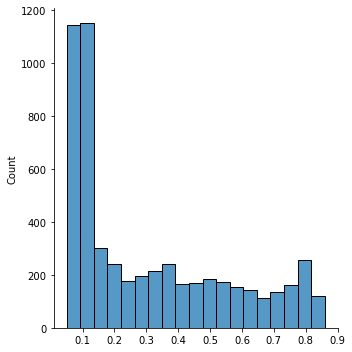

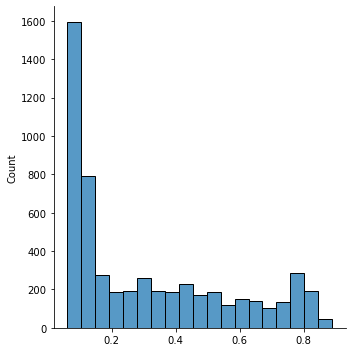

In [30]:
#Detailed breakdown of Texts
colnames = ["Topic" + str(i) for i in range(lda_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df['processed_text']))]
df_doc_topic = pd.DataFrame(np.round(lda_topics,2),columns=colnames,index=docnames)
significant_topic = np.argmax(df_doc_topic.values,axis=1)
df_doc_topic['dominant_topic'] = significant_topic 
df_doc_topic
sns.displot(df_doc_topic['Topic0'].values)
sns.displot(df_doc_topic['Topic1'].values)
sns.displot(df_doc_topic['Topic2'].values)

In [202]:
df.dominant_topic.value_counts().sort_index()

0    2209
1    1621
2    1614
Name: dominant_topic, dtype: int64

# Model for Topic Modelling

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(lda_topics, df['dominant_topic'], test_size = 0.2, random_state = 1)

Best: -0.008063 using {'n_estimators': 600}
-0.009010 (0.004887) with: {'n_estimators': 50}
-0.008592 (0.004948) with: {'n_estimators': 100}
-0.008441 (0.004839) with: {'n_estimators': 150}
-0.008306 (0.004778) with: {'n_estimators': 200}
-0.008246 (0.004771) with: {'n_estimators': 250}
-0.008187 (0.004785) with: {'n_estimators': 300}
-0.008131 (0.004811) with: {'n_estimators': 350}
-0.008104 (0.004829) with: {'n_estimators': 400}
-0.008094 (0.004842) with: {'n_estimators': 450}
-0.008083 (0.004845) with: {'n_estimators': 500}
-0.008069 (0.004851) with: {'n_estimators': 550}
-0.008063 (0.004850) with: {'n_estimators': 600}
-0.008067 (0.004856) with: {'n_estimators': 650}
-0.008074 (0.004860) with: {'n_estimators': 700}
-0.008070 (0.004860) with: {'n_estimators': 750}
-0.008080 (0.004869) with: {'n_estimators': 800}
-0.008081 (0.004870) with: {'n_estimators': 850}
-0.008084 (0.004873) with: {'n_estimators': 900}
-0.008090 (0.004882) with: {'n_estimators': 950}
-0.008089 (0.004884) with:

Text(0, 0.5, 'Log Loss')

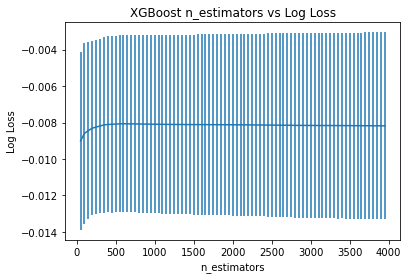

In [16]:
# XGBoost: Tuning n_estimators
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot

label_encoded_y = LabelEncoder().fit_transform(y_train)
# grid search
model = XGBClassifier()
n_estimators = range(50, 4000, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
#pyplot.savefig('n_estimators.png')

In [17]:
#XGBoost Evaluation
xgbc = XGBClassifier(n_estimators=600)
xgbc_lda = xgbc.fit(x_train,y_train)
xgbc_ytest = xgbc_lda.predict(x_test)
(np.sum(xgbc_ytest == y_test)/y_test.shape[0]) * 100 #Accuracy

99.44903581267218

In [187]:
from sklearn.svm import SVC
#SVM Evaluation
pd.DataFrame(y_train).value_counts()
svc = SVC(C=1.0, random_state=1, kernel='poly')
svc.fit(x_train, y_train)
x_test_predicted = svc.predict(x_test)
np.sum(x_test_predicted == y_test)
(np.sum(x_test_predicted == y_test)/y_test.shape[0]) *100 #Accuracy

99.72451790633609